In [1]:
##########################################################################
# ADD SOME GENERAL INFO and LICENSE -> @ajay6763
##########################################################################
from __future__ import division
import sys
import obspy
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees
from obspy.geodetics.base import gps2dist_azimuth
from obspy.signal.trigger import recursive_sta_lta_py
from scipy import signal

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import matplotlib.transforms as mtransforms
########### 
#import bp lib
import bp_lib as bp_lib



In [2]:
##########################################################################
# Event info
##########################################################################
origin_time          = obspy.UTCDateTime(2016, 1, 3, 23, 5, 22)
event_lat            = 24.80360
event_long           = 93.65050
event_depth          = 55.0 # km
##########################################################################
# data info
##########################################################################
Array_name           = 'AU_test'
stations             = './data/test/bp_stations_'+str(Array_name)+'/*'
inv                  = obspy.read_inventory(stations)
wavefroms            = './data/test/bp_waveforms_'+str(Array_name)+'/*.mseed'

stream_orig          = obspy.read(wavefroms)
stream_work          = stream_orig.copy()
##########################################################################
# BP parameters
##########################################################################
model = TauPyModel(model="ak135")
#model               = TauPyModel(model="iasp91")
Start_P_cut_time    = 60  #before P arrival in seconds
End_P_cut_time      = 120 #After P arrival seconds
sps                 = 20  #samples per seconds
bp_l                = 0.2 #Hz
bp_u                = 5   #Hz
stack_start         = 0   #in seconds
stack_end           = 60  #in seconds
smooth_time_window  = 5   #seconds
source_grid_size    = 0.5 #degrees
source_grid_extend  = 2   #degrees
min_distance        = 30  #degrees
max_distance        = 90  #degress
##########################################################################
# Making potential sources grid
##########################################################################
slong,slat          = bp_lib.make_source_grid(event_long,event_lat,source_grid_extend,source_grid_size)

c:\users\kumar\appdata\local\programs\python\python37\lib\site-packages\obspy\io\stationxml\core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
c:\users\kumar\appdata\local\programs\python\python37\lib\site-packages\obspy\io\stationxml\core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
c:\users\kumar\appdata\local\programs\python\python37\lib\site-packages\obspy\io\stationxml\core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


In [3]:
##########################################################################
# Load stations inventory
##########################################################################
# Loading the station inventory and data for AU network
# Getting stations name, lat, and longs in a list
# This is done to make a lookup such that when I read the traces
# I can figure out the locations of those traces.
# What I do not understand is why the station and event is not
# included into the trace.stats, like we have in sac.
# May be I am missing something when I download or
# there is clever way or function do this.
sta_net             = []
sta_name            = []
sta_lat             = []
sta_long            = []
sta_dist            = []
sta_azimuth         = []
sta_P_arrival_taup  = []
for net in inv:
    for sta in net:
        sta_name.append(sta.code)
        sta_net.append(net.code)
        for channels in sta:
                sta_lat.append(channels.latitude)
                sta_long.append(channels.longitude)
                sta_dist.append(locations2degrees(event_lat,event_long,channels.latitude,channels.longitude))
                s1,s2,s3=gps2dist_azimuth(event_lat,event_long,channels.latitude,channels.longitude, a=6378137.0, f=0.0033528106647474805)
                sta_azimuth.append(s3)
                #arrivals       = model.get_travel_times(source_depth_in_km=event_depth,distance_in_degree=locations2degrees(event_lat,event_long,channels.latitude,channels.longitude),phase_list=["P"])
                #arr            = arrivals[0]
                #t_travel       = arr.time;
                #sta_P_arrival_taup.append(t_travel)
print('Total number of stations:', len(sta_lat))

Total number of stations: 104


In [4]:
##########################################################################
# reading wavefrom data and assigning station info to them 
# I do this by haveing lists of stations with all the info read and 
# extracted above and then look-up for the station name in the waveform
# and doing the assignment
##########################################################################
# Looping through the network traces and writing 
# station latitude and station longitude 
sta_sps=[]
for t in stream_work:
        sta          = t.stats.station
        if sta in sta_name:
            ind                          = sta_name.index(sta)
            t.stats['Dist']              = sta_dist[ind]
            t.stats['Azimuth']           = sta_azimuth[ind]
            t.stats['station_latitude']  = sta_lat[ind]
            t.stats['station_longitude'] = sta_long[ind]
            t.stats['origin_time']       = origin_time
            arrivals                     = model.get_travel_times(source_depth_in_km=event_depth,distance_in_degree=locations2degrees(event_lat,event_long,sta_lat[ind],sta_long[ind]),phase_list=["P"])
            arr                          = arrivals[0]
            t_travel                     = arr.time;
            t.stats['P_arrival']         = origin_time + t_travel 
            sta_sps.append(t.stats.sampling_rate)
        else:
            stream_work.remove(t)
print("Total no stations with data:", len(stream_work))
print("Sampling rate of the waveform data:", np.unique(sta_sps))


Total no stations with data: 104
Sampling rate of the waveform data: [  20.   40.   50.  100.]


In [5]:
##########################################################################
# SPS and distance check
##########################################################################
# make a copy of the data and leave the original
print('Total no of traces before decimation criteria:', len(stream_work))
for t in stream_work:
    if (t.stats.sampling_rate==20. or t.stats.sampling_rate==40. or t.stats.sampling_rate==80.
        or t.stats.sampling_rate==100. or t.stats.sampling_rate==120. or t.stats.sampling_rate==200.):
        pass
    else:
        stream_work.remove(t)
######### decimating
for t in stream_work:
    if (t.stats.sampling_rate   == 20.):
        pass
    elif (t.stats.sampling_rate == 40.):
        t.decimate(2)
    elif (t.stats.sampling_rate == 50.):
        t.resample(20.0)
    elif (t.stats.sampling_rate == 80.):
        t.decimate(4)
    elif (t.stats.sampling_rate == 100.):
        t.decimate(5)
    elif (t.stats.sampling_rate == 120.):
        t.decimate(6)
    elif (t.stats.sampling_rate == 200.):
        t.decimate(10)
    else:
        print("There are some traces that cannot be decimated 20 SPS. Please check the SPS of your data")
        sys.exit(...)
print('Total no of traces after decimation criteria:', len(stream_work))

Total no of traces before decimation criteria: 104
Total no of traces after decimation criteria: 73


In [6]:
print('Total no of traces before  distance criteria:', len(stream_work))
for t in stream_work:
    if (t.stats.Dist > min_distance and t.stats.Dist < max_distance):
        pass
    else:
        stream_work.remove(t)
print('Total no of traces after distance criteria:', len(stream_work))

Total no of traces before  distance criteria: 73
Total no of traces after distance criteria: 70


In [7]:
##########################################################################
# CUtting 30 seconds before P arrival and 120 seconds after and filter
##########################################################################
stream_cut=stream_work.copy()
for t in stream_cut:
        #t.trim(t.stats['P_arrival']-Start_P_cut_time,t.stats['P_arrival']+End_P_cut_time)
        t.trim(t.stats['P_arrival']-Start_P_cut_time,t.stats['P_arrival']+End_P_cut_time)

In [8]:
##########################################################################
# Now, there might be stations where arrival time is way off
# or the data is not good. 
# So I run a simple sta-lta for the trimed traces 
# and set a threshold (5s) if the maximum time from sta-lta 
# is greater than that then i reject the trace 
# @ajay6763: WRITE ABOUT THE ARGUMENTS THAT GOES Into
#            THE STA-LTA FUNCTION
# Note: I have choosen 10 seconds as threshold such that if the difference
# between the arrival time from 1D velocity model and the STA-LTA pick
# is greater than it, then I assume something is not right with the station
# and I simply throw the data for that station. 
##########################################################################
print('Initial no of traces = ', len(stream_cut) )
for t in stream_cut:
        t.detrend
        t.normalize
        cft         = obspy.signal.trigger.recursive_sta_lta_py(t.data, int(1 * t.stats.sampling_rate), 
                      int(5 * t.stats.sampling_rate))
        time        = np.arange(0, t.stats.npts / t.stats.sampling_rate, t.stats.delta)
        ind         = np.argmax(cft)
        if (abs(time[ind]-Start_P_cut_time) > 5 ):
            stream_cut.remove(t)
        else:
            t.stats['STA_LTA_shift'] = time[ind]-Start_P_cut_time 
            
print('No of traces after STA-LTA= ', len(stream_cut) )

Initial no of traces =  70
No of traces after STA-LTA=  44


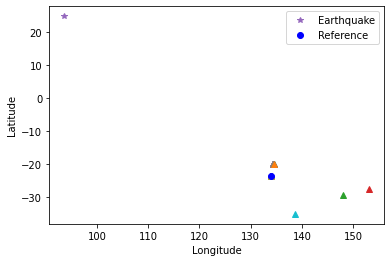

In [9]:
##########################################################################
# finding reference station
# the the station in the middle of the array
# I will take the mean of the distance and azimuth and take the station closest to it
##########################################################################
sta_dist=[]
sta_azimuth=[]
for tr in stream_cut:
    sta_dist.append(tr.stats.Dist)
    sta_azimuth.append(tr.stats.Azimuth)

mean_dist = np.median(sta_dist)
dist=np.array((mean_dist-sta_dist)**2);
index_dist=dist.argmin(); 
            
mean_azimuth = np.median(sta_azimuth)
dist=np.array((mean_azimuth-sta_azimuth)**2);
index_azimuth=dist.argmin(); 

Ref_station_index=index_dist
##########################################################################
# plotting reference station
# If the station does not turn out to be in the centre of the array
# you choose it in a ad-hoc fashion by changing the index of the reference
# station above
##########################################################################
bp_lib.plot_array(stream_cut,event_long,event_lat,Array_name,Ref_station_index)


In [10]:
##########################################################################
# Now will cross-correlat the all the treces 
# with the reference trace and save the 
# shift and correlation value which will 
# be used form 3D velocity varition corrections
# and weight traces when stacking, respectively.
##########################################################################
ref_trace = stream_cut[Ref_station_index]
for tr in stream_cut:
    cc = obspy.signal.cross_correlation.correlate(ref_trace, tr, 10)
    shift, value = obspy.signal.cross_correlation.xcorr_max(cc)
    #xcorr_pick_correction(pick1, trace1, pick2, trace2, t_before, t_after, cc_maxlag, filter=None, filter_options={}, plot=False, filename=None)
    #shift, value = obspy.signal.cross_correlation.xcorr_pick_correction(ref_trace.stats.P_arrival, ref_trace, 
    #    tr.stats.P_arrival, tr, 5, 5, 5, plot=False) #,filter="bandpass",filter_options={'freqmin': bp_l, 'freqmax': bp_u})
    tr.stats['Corr_coeff'] = shift/sps
    tr.stats['Corr_shift']  = value
    #print("shift",shift)
    #print("corr",value)

In [11]:
count=0;
for tr_ in stream_cut:
    dist=((tr.stats.station_latitude-tr_.stats.station_latitude)**2 + 
         (tr.stats.station_longitude-tr_.stats.station_longitude)**2 )**0.2;
    if ( dist <= 1):
        count=count+1;
    else:
        continue
    tr.stats['Station_weight'] = count


In [12]:
##########################################################################
# Filtering traces
##########################################################################
stream_cut_filtered=stream_cut.copy()
for tr in stream_cut_filtered:
    tr.detrend
    tr.filter('bandpass',freqmin=bp_l,freqmax=bp_u,corners=5)
    tr.detrend
    tr.normalize

In [13]:
##########################################################################
# Selecting traces for BP. 
# Use can choose correlation threshold
# If not then simple set threshold to 0
# and all the traces will be used for in
# back-projection
##########################################################################
stream_for_bp = stream_cut_filtered.copy()
threshold_correlation=0.0
print('No of traces before cross-correlation threshold = ', len(stream_for_bp))
for tr in stream_for_bp:
    if (abs(tr.stats.Corr_coeff) >= threshold_correlation):
        #time = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)
        #plt.plot(time,tr.data/np.max(tr.data))
        count=count+1
    else:
        stream_for_bp.remove(tr)
print('No of traces after cross-correlation threshold = ', len(stream_for_bp))


No of traces before cross-correlation threshold =  44
No of traces after cross-correlation threshold =  44


In [14]:
##########################################################################
# doing the back-projection
# beam variable is the "beast". 
# This will be an array who has size = [len[slat], len(stack_window)]
# Basically this contains the traces from all the stations from an array 
# that are alligned according to the arrival-time of the P-wave from the each source
# grid point.  
##########################################################################
beam=[];
# looping throught all potential source location 
for j in range(len(slat)):
    stack = []
    # looping through all stations in the array 
    for t in stream_for_bp:
        ##################################################################
        # Taup part
        ##################################################################
        distance        = obspy.geodetics.locations2degrees(slat[j],slong[j],t.stats.station_latitude,t.stats.station_longitude)
        ### travel time
        arrivals        = model.get_travel_times(source_depth_in_km=event_depth,distance_in_degree=distance,phase_list=["P"])
        arr             = arrivals[0]
        t_travel        = arr.time;
        #################################################################
        # total travel time adjusted for the correlation 
        # time shift
        #################################################################
        t_total         = origin_time + t_travel + t.stats.Corr_shift 
        #################################################################
        # Cutting the trace starting from t_total above
        # untill the stacking window in seconds defined at the top 
        #################################################################
        cut             = []
        cut,width,sign  = bp_lib.cut_window(t,t_total,stack_start,stack_end)
        #################################################################
        # Multiplying by the correlation and divifing by the
        # station density 
        #################################################################
        cut             = (cut*t.stats.Corr_coeff)/t.stats.Station_weight
        stack           = np.append(stack,cut)
        
    #####################################################################
    stack_reshaped      = np.reshape(stack, (len(stream_for_bp), width))
    sum_stack           = np.sum(stack_reshaped,axis=0)
    beam                = np.append(beam,sum_stack)
    print("Progress =",((j/len(slat))*100),"%" )
##########################################################################
## reshaping beam
beam_reshaped           = np.reshape(beam, (len(slat), width))
##########################################################################
# saving beam 
file_save = 'beam_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'.dat'
np.savetxt(file_save,beam_reshaped)

AttributeError: Station_weight

In [ ]:
##########################################################################
## calculating STF from the waveforms
STF_start           = 0
STF_end             = 60
stf                 = []
for t in stream_for_bp:
        ##################################################################
        if(abs(t.stats.Corr_coeff) >= threshold_correlation):
            # cut,paste,and stack
            stf            = []
            cut            = []
            cut,width,sign = bp_lib.cut_window(t,t.stats.P_arrival+t.stats.Corr_shift,STF_start,STF_end)
            stf            = (cut*t.stats.Corr_coeff)/t.stats.Station_weight
        else:
            pass

#Taking square becaouse we are interested in the power
stf=stf**2 
#Moving time window average 
stf_averaged  = bp_lib.moving_average_time(stf[:],smooth_time_window*sps)
#Normalizing 
stf_averaged  = stf_averaged/np.max(stf_averaged)
stf_time      = np.arange(0, len(stf_averaged) / ref_trace.stats.sampling_rate, ref_trace.stats.delta)
STF_array     = np.copy(stf_time)
STF_array     = np.column_stack((STF_array,stf_averaged)) #
#################
#plotting
#plt.plot(STF_array[:,0],STF_array[:,1])
#plt.xlabel('Time (s)')
#plt.ylabel('Normalized Amplitude')
#plt.savefig(str(Array_name)+'_STF.png')
#saving STF 
file_save    = 'STF_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'.dat'
np.savetxt(file_save,STF_array)

m,n          = np.shape(beam_reshaped)
# space wise smoothening
stack_start  = 0
stack_end    = 60
# space wise smoothening
beam_averaged_time=np.zeros((m,stack_end-stack_start))
for i in range(stack_end-stack_start):
    beam_averaged_time[:,i] = bp_lib.moving_average_time_beam(beam_reshaped[:,i*sps:(i+smooth_time_window-1)*sps]**2)
beam_averaged_time=beam_averaged_time/np.max(beam_averaged_time)

#bp_lib.plot_results(beam_averaged_time,STF_array,event_long,event_lat,Array_name,slong,slat,stack_start,stack_end)


# Cumulative energy
temp     =np.sum(beam_averaged_time[:,stack_start:stack_end],axis=1)
np.size(temp)
m,n=np.shape(beam_averaged_time)
cumulative_energy=np.zeros((m,3))
cumulative_energy[:,2]=temp/np.max(temp)
cumulative_energy[:,0]=slong
cumulative_energy[:,1]=slat

file_save='cumulative_energy_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'.dat'
np.savetxt(file_save,cumulative_energy)

m,n=np.shape(beam_averaged_time)
peak_energy=np.zeros((n,4))
for i in range(n):
    ind              = np.argmax(beam_averaged_time[:,i])
    peak_energy[i,0] = i
    peak_energy[i,1] = slong[ind]
    peak_energy[i,2] = slat[ind]
    peak_energy[i,3] = beam_averaged_time[ind,i]

file_save='Peak_energy_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'.dat'
np.savetxt(file_save,peak_energy)

colors=range(0,n,1)
fig, ax           = plt.subplots(1, 2, sharex=False, sharey=False,figsize=(10, 6))
tri               = Triangulation(cumulative_energy[:,0],cumulative_energy[:,1])
energy            = ax[0].tricontourf(tri, cumulative_energy[:,2],cmap='hot',levels=np.arange(0, 1,0.1))
event             = ax[0].plot(event_long,event_lat,'*',markersize=20)
cmap              = plt.get_cmap('cubehelix', 10)
cmap.set_under('gray')
peak              = ax[0].scatter(peak_energy[:,1],peak_energy[:,2],c=peak_energy[:,0],s=peak_energy[:,3]*500,cmap=cmap,vmin=0,vmax=peak_energy[:,0].max())
fig.colorbar(energy,ax=ax[0],label='Cumulative energy',orientation='horizontal')
fig.colorbar(peak,ax=ax[0],label='Peak energy',orientation='vertical')

stf_combined     = ax[1].plot(STF_array[:,0],STF_array[:,1])
stf              = ax[1].plot(STF_array[:,0],STF_array[:,1])

ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Normalized Amplitude')
fig.savefig('BP_Peak_energy_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'.png')


print("Progress back-projection DONE!!")